# Predicting the stock market

## Introduction

In this project we aim at predicting whether the stock market will go up or down given its past evolution using a simple machine-learning model. 
Our goal is to exemplify how such models can be used to analyze time series and make predictions, and to give an estimate of their performance in a specific context. 

We will work with historical data on the price of the S&P500 index, a stock market index maintained by [S&P Dow Jones Indices LLC](https://www.standardandpoors.com/en_US/web/guest/home) which aggregates stocks of 500 large compagnies listed on stock exchanges in the United States of America (USA). 
It is seen as one of the best representations of the wider USA stock market.

A word of warning: the model we develop in this project is *not* suitable for real-world trading. 
Trading stocks incurs risks, which should be carefully evaluated before engaging in it, something the model below does not do. 
This model should be used for learning and illustrative purposes only.

## The Dataset

The dataset we will work with, in the file `sphist.csv`, contains a daily record of the price of the S&P500 Index from 1950 to 2015. 
It has 7 columns: 
* `Date`: the date of each record, 
* `Open`: the opening trade price on this date, 
* `High`: the highest price reached on that day, 
* `Low`: the lowest price reached on that day, 
* `Close`: the closing price at the end of the day, 
* `Volume`: the number of trades,
* `Adj Close`: the closing price adjusted to include corporate actions (such as stock splits, dividends, and rights offerings).

If we aimed at making investment advice, the accuracy of the data would need to be checked carefully. 
However, as this project is only illustrative, we shall skip this step and assume it is correct. 

Let us first import the packages and functions we will need: 

In [1]:
# Pyplot from matplotlib
from matplotlib import pyplot as plt

# Pandas for working with datasets
import pandas as pd

# datetime to work with dates
from datetime import datetime

# a linear regression model from scikit-learn
from sklearn.linear_model import LinearRegression

# the mean squared error metric from sckit-learn
from sklearn.metrics import mean_squared_error

# the square root function from numpy
from numpy import sqrt

We load the data of `sphist.csv` in the dataframe `data` and print the first few lines:

In [2]:
data = pd.read_csv('../Data/sphist.csv')
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16590 entries, 0 to 16589
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       16590 non-null  object 
 1   Open       16590 non-null  float64
 2   High       16590 non-null  float64
 3   Low        16590 non-null  float64
 4   Close      16590 non-null  float64
 5   Volume     16590 non-null  float64
 6   Adj Close  16590 non-null  float64
dtypes: float64(6), object(1)
memory usage: 907.4+ KB
None


,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883


There seems to be no missing values.
In the following, it will be convenient to have entries of the `Date` column in `datetime` format. 
Let us do the conversion and sort the rows in ascending date order:

In [3]:
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)
data = data.reset_index(drop=True)
data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
1,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
2,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
3,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
4,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


Let us plot the `Adj Close` column to gget a feel for how it looks:

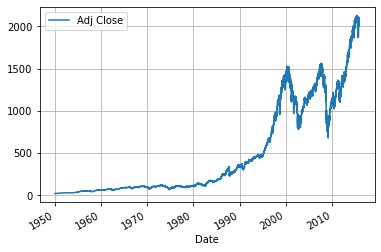

In [4]:
data.plot(x = 'Date', y = 'Adj Close')
plt.grid()
plt.show()

The plot looks relatively smooth on large scales. 
This indicates that data on the adjusted closing price averaged over some period of time (ay, about a year) could give a good estimate of prices in the near future.

Globally, and discarding for the moment fluctuations over time scales of a month of less, the price is a monotonically increasing function of time between the years 1950 and 2000, with noticeable accelerations after 1980 and after 1995. The price drops sharply between 2000 and 2003 (corresponding to the early 2000s recession), then rises again until 2008 when it goes a bit above where it was in 2000, before sharpjy dropping in one year (this corresponds to the financial crisis of 2008). the price then increases for a few years, going above its previous maximum.

Let us focus on the last few values:

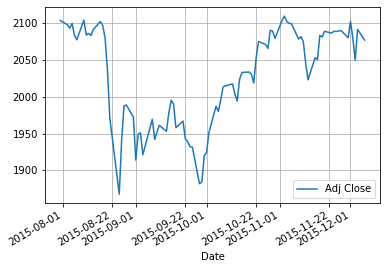

In [5]:
min_i = 16500
data[min_i:].plot(x = 'Date', y = 'Adj Close')
plt.grid()
plt.show()

While the day-to-day variation can be significant, a trend seems to emerge on time scales of a few days.

## Adding indicators

Let us now add a few columns to the dataframe which give a sense, for each row, of how the stock market has evolved in the recent past. 
We focus on time-scales longer than a day, typically a week to a year. 
The most important columns are thus `Volume` and `Adj Close`. 
We choose the following indicators, for each of these columns: 
* the mean value over the previous 5 trading days (corresponding to a calendar week when there is no bank holliday),
* the standard deviation over the previous 5 trading days, 
* the mean value over the previous 30 days (i.e., close to a month), 
* the standard deviation over the previous 30 days. 
* the mean value over the previous 365 days (i.e., close to a year), 
* the standard deviation over the previous 365 days. 

For each of them, we do not include the values of the current row.

In [6]:
def mean_n_trading_days(col, n_days=5):
    '''
    Returns a series where each entry is the mean value of the previous  
    n_days entries in the column col. 
    
    col: string
    '''
    mean = data[col].rolling(n_days).mean()
    return mean.shift(periods=1)

def std_n_trading_days(col, n_days=5):
    '''
    Returns a series where each entry is the standard deviation of the previous
    n_days entries in the column col.
    
    col: string
    '''
    mean = data[col].rolling(n_days).std()
    return mean.shift(periods=1)

def mean_n_days(col, n_days=30):
    '''
    Returns a series where each entry is the mean value of the previous n_days 
    days.
    
    col: string
    '''
    data_time_as_index = data.set_index(data['Date'])[col]
    return data_time_as_index.rolling(str(n_days)+'d').mean().reset_index(drop=True).shift(periods=1)

def std_n_days(col, n_days=30):
    '''
    Returns a series where each entry is the standard deviation of the previous 
    n_days days.
    
    col: string
    '''
    data_time_as_index = data.set_index(data['Date'])[col] 
    return data_time_as_index.rolling(str(n_days)+'d').std().reset_index(drop=True).shift(periods=1)

data['mean_5_Volume'] = mean_n_trading_days('Volume')
data['std_5_Volume'] = std_n_trading_days('Volume')
data['mean_5_Adj_Close'] = mean_n_trading_days('Adj Close')
data['std_5_Adj_Close'] = std_n_trading_days('Adj Close')
data['mean_30_Volume'] = mean_n_days('Volume')
data['std_30_Volume'] = std_n_days('Volume')
data['mean_30_Adj_Close'] = mean_n_days('Adj Close')
data['std_30_Adj_Close'] = std_n_days('Adj Close')
data['mean_365_Volume'] = mean_n_days('Volume', 365)
data['std_365_Volume'] = std_n_days('Volume', 365)
data['mean_365_Adj_Close'] = mean_n_days('Adj Close', 365)
data['std_365_Adj_Close'] = std_n_days('Adj Close', 365)

data.head(10)

,Date,Open,High,Low,Close,Volume,Adj Close,mean_5_Volume,std_5_Volume,mean_5_Adj_Close,std_5_Adj_Close,mean_30_Volume,std_30_Volume,mean_30_Adj_Close,std_30_Adj_Close,mean_365_Volume,std_365_Volume,mean_365_Adj_Close,std_365_Adj_Close
0,1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000.0,16.660000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000.0,16.850000,NaN,NaN,NaN,NaN,1.260000e+06,NaN,16.660000,NaN,1.260000e+06,NaN,16.660000,NaN
2,1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000.0,16.930000,NaN,NaN,NaN,NaN,1.575000e+06,445477.272148,16.755000,0.134350,1.575000e+06,445477.272148,16.755000,0.134350
3,1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000.0,16.980000,NaN,NaN,NaN,NaN,1.900000e+06,645058.136915,16.813333,0.138684,1.900000e+06,645058.136915,16.813333,0.138684
4,1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000.0,17.080000,NaN,NaN,NaN,NaN,1.927500e+06,529551.697193,16.855000,0.140594,1.927500e+06,529551.697193,16.855000,0.140594
5,1950-01-10,17.030001,17.030001,17.030001,17.030001,2160000.0,17.030001,2046000.0,529650.828377,16.900,0.157956,2.046000e+06,529650.828377,16.900000,0.157956,2.046000e+06,529650.828377,16.900000,0.157956
6,1950-01-11,17.090000,17.090000,17.090000,17.090000,2630000.0,17.090000,2226000.0,298043.620968,16.974,0.089051,2.065000e+06,476014.705655,16.921667,0.150920,2.065000e+06,476014.705655,16.921667,0.150920
7,1950-01-12,16.760000,16.760000,16.760000,16.760000,2970000.0,16.760000,2374000.0,272084.545684,17.022,0.067602,2.145714e+06,484178.243448,16.945714,0.151752,2.145714e+06,484178.243448,16.945714,0.151752
8,1950-01-13,16.670000,16.670000,16.670000,16.670000,3330000.0,16.670000,2458000.0,382452.611444,16.988,0.134796,2.248750e+06,534667.787376,16.922500,0.155081,2.248750e+06,534667.787376,16.922500,0.155081
9,1950-01-16,16.719999,16.719999,16.719999,16.719999,1460000.0,16.719999,2722000.0,446172.612337,16.926,0.196545,2.368889e+06,616470.689580,16.894445,0.167713,2.368889e+06,616470.689580,16.894445,0.167713


## Training and test sets

We want to train our models on data from 2012 and before, and test it on the later data. 
We need to remove the rows corresponding to dates earlier than 1st January 1951 as 4 of our indicators are not defined for them.

In [7]:
train = data[(data['Date'] >= datetime.strptime('01-01-1951', '%d-%m-%Y')) & (data['Date'] < datetime.strptime('01-01-2013', '%d-%m-%Y'))]
test = data[data['Date'] >= datetime.strptime('01-01-2013', '%d-%m-%Y')]

display(train)
display(test)

,Date,Open,High,Low,Close,Volume,Adj Close,mean_5_Volume,std_5_Volume,mean_5_Adj_Close,std_5_Adj_Close,mean_30_Volume,std_30_Volume,mean_30_Adj_Close,std_30_Adj_Close,mean_365_Volume,std_365_Volume,mean_365_Adj_Close,std_365_Adj_Close
249,1951-01-02,20.770000,20.770000,20.770000,20.770000,3.030000e+06,20.770000,3.064000e+06,4.136182e+05,20.220000,0.217140,2.730952e+06,7.664588e+05,19.734285,0.380205,2.009237e+06,6.315379e+05,18.397269,1.059922
250,1951-01-03,20.690001,20.690001,20.690001,20.690001,3.370000e+06,20.690001,3.126000e+06,3.701081e+05,20.360000,0.304385,2.821500e+06,7.437336e+05,19.801000,0.448329,2.013320e+06,6.335663e+05,18.406760,1.068383
251,1951-01-04,20.870001,20.870001,20.870001,20.870001,3.390000e+06,20.870001,3.268000e+06,2.690167e+05,20.514000,0.204524,2.864500e+06,7.496138e+05,19.885500,0.448676,2.021760e+06,6.375323e+05,18.422880,1.072317
252,1951-01-05,20.870001,20.870001,20.870001,20.870001,3.390000e+06,20.870001,3.358000e+06,1.976613e+05,20.628000,0.214057,2.937000e+06,7.252158e+05,19.963500,0.478003,2.027760e+06,6.433195e+05,18.438960,1.078758
253,1951-01-08,21.000000,21.000000,21.000000,21.000000,2.780000e+06,21.000000,3.324000e+06,1.663731e+05,20.726001,0.181879,3.006000e+06,6.974948e+05,20.034500,0.502546,2.031120e+06,6.482330e+05,18.454720,1.085385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15846,2012-12-24,1430.150024,1430.150024,1424.660034,1426.660034,1.248960e+09,1426.660034,4.108678e+09,6.990482e+08,1437.360010,7.622009,3.469150e+09,7.003539e+08,1419.473330,12.700733,3.628754e+09,5.723470e+08,1376.185400,49.165225
15847,2012-12-26,1426.660034,1429.420044,1416.430054,1419.829956,2.285030e+09,1419.829956,3.667348e+09,1.477523e+09,1436.620019,8.589693,3.456959e+09,7.374955e+08,1420.307140,12.563141,3.624814e+09,5.852313e+08,1376.830720,48.761458
15848,2012-12-27,1419.829956,1422.800049,1401.800049,1418.099976,2.830180e+09,1418.099976,3.263906e+09,1.535105e+09,1431.228003,9.058684,3.425343e+09,7.737039e+08,1420.951898,12.148393,3.625432e+09,5.837273e+08,1377.448320,48.320622
15849,2012-12-28,1418.099976,1418.099976,1401.579956,1402.430054,2.426680e+09,1402.430054,3.055982e+09,1.502584e+09,1427.685986,10.208568,3.401870e+09,7.843645e+08,1421.864281,11.085565,3.627353e+09,5.802934e+08,1378.122160,47.701794


,Date,Open,High,Low,Close,Volume,Adj Close,mean_5_Volume,std_5_Volume,mean_5_Adj_Close,std_5_Adj_Close,mean_30_Volume,std_30_Volume,mean_30_Adj_Close,std_30_Adj_Close,mean_365_Volume,std_365_Volume,mean_365_Adj_Close,std_365_Adj_Close
15851,2013-01-02,1426.189941,1462.430054,1426.189941,1462.420044,4.202600e+09,1462.420044,2.399036e+09,7.366851e+08,1418.641992,9.820801,3.319409e+09,8.219518e+08,1422.285492,11.789673,3.631677e+09,5.731841e+08,1379.354160,46.626674
15852,2013-01-03,1462.420044,1465.469971,1455.530029,1459.369995,3.829730e+09,1459.369995,2.989764e+09,7.674944e+08,1425.793994,22.261321,3.375825e+09,8.427015e+08,1424.933496,14.413044,3.632713e+09,5.739834e+08,1380.095600,46.466988
15853,2013-01-04,1459.369995,1467.939941,1458.989990,1466.469971,3.424290e+09,1466.469971,3.298704e+09,7.224721e+08,1433.702002,26.274326,3.404926e+09,8.480768e+08,1427.549493,15.688023,3.633661e+09,5.741128e+08,1380.823879,46.275800
15854,2013-01-07,1466.469971,1466.469971,1456.619995,1461.890015,3.304970e+09,1461.890015,3.417526e+09,6.733364e+08,1443.376001,27.945242,3.363444e+09,8.243218e+08,1430.408990,17.310877,3.630095e+09,5.726249e+08,1381.565519,46.156095
15855,2013-01-08,1461.890015,1461.890015,1451.640015,1457.150024,3.601600e+09,1457.150024,3.593184e+09,4.153739e+08,1455.267993,16.453319,3.379947e+09,8.443998e+08,1433.582102,18.363509,3.628687e+09,5.729912e+08,1382.301839,45.962146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16585,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883,3.207544e+09,1.099518e+09,2087.024023,3.916109,3.795680e+09,6.502637e+08,2080.616504,21.948900,3.633465e+09,6.821865e+08,2061.084049,55.256933
16586,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010,3.232372e+09,1.111591e+09,2090.231982,7.956808,3.791700e+09,6.340609e+08,2081.664760,21.925833,3.631692e+09,6.813953e+08,2061.279247,55.316673
16587,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117,3.245514e+09,1.121578e+09,2088.306006,9.333599,3.800778e+09,6.349485e+08,2080.496187,21.318663,3.632739e+09,6.816830e+08,2061.330676,55.327616
16588,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941,3.536224e+09,1.181180e+09,2080.456006,19.599946,3.802417e+09,6.362693e+08,2077.630952,21.227940,3.635492e+09,6.830015e+08,2061.232620,55.326382


## Linear Regression 

In this section we build a simple linear regression model to predict the adjusted closing price from the 6 indicators. 
Notice that these indicators only contain data on the about past prices. 
We discard the original columns `Open`, `High`, `Close`, and `Volume` which contain information not available before trading opens on a given day. 

Let us first see whether these indicators are correlated with the adjusted closing price:

In [8]:
train.iloc[:,6:].corr()['Adj Close'].sort_values(ascending=False)

Adj Close             1.000000
mean_5_Adj_Close      0.999758
mean_30_Adj_Close     0.999281
mean_365_Adj_Close    0.991082
std_365_Adj_Close     0.784491
std_30_Adj_Close      0.782502
mean_30_Volume        0.743319
std_5_Adj_Close       0.742657
mean_365_Volume       0.738940
mean_5_Volume         0.738801
std_365_Volume        0.662966
std_30_Volume         0.643434
std_5_Volume          0.596770
Name: Adj Close, dtype: float64

They all seem to be significantly correlated with the adjusted closing price, especially the mean values: there seems to be a very strong correlation between the avegage value in the last few days, last month, or even last year, and the asjusted closing price. 

Let us now build the linear regression model and fit it on the train data. 

In [9]:
def train_and_test(features, target):
    '''
    trains a linear regression model and prints the rmse for the test data
    '''

    # build and train the model
    lr1 = LinearRegression()
    lr1.fit(train[features], train[target])

    # test the model and return the root-mean-squared error
    rmse1 = sqrt(mean_squared_error(lr1.predict(test[features]), test[target]))

    print('rmse: ' + str(rmse1) + ', rmse/std: ' + str(rmse1 / test[target].std()))

We start with only one feature: `mean_5_Adj_Close`, which has the strongest correlation with the target.

In [10]:
features = ['mean_5_Adj_Close']
target = 'Adj Close'

train_and_test(features, target)

rmse: 22.20955744921972, rmse/std: 0.11544085549934081


The root mean squared error is smaller than 12% of the standard deviation of the target value. 
This linear regression model thus performs much better than taking the global average.

Let us see if adding the average over 30 days improves the results:

In [11]:
features = ['mean_5_Adj_Close', 'mean_30_Adj_Close']
target = 'Adj Close'

train_and_test(features, target)

rmse: 22.212660723905625, rmse/std: 0.11545698570298893


This lead to very similar results. 
Let us instead use the standard deviation over the last 5 trading days: 

In [12]:
features = ['mean_5_Adj_Close', 'std_5_Adj_Close']
target = 'Adj Close'

train_and_test(features, target)

rmse: 22.118592932708804, rmse/std: 0.11496804006255809


The resulting rmse is marginally smaller, but the difference is not significant.

Let us now take the opposite point of view and use all indicators as features:

In [13]:
features = list(train.columns)[7:]
target = 'Adj Close'

train_and_test(features, target)

rmse: 22.273770264458264, rmse/std: 0.11577462092182199


The rmse is very close to the previous one, although a little bit higher.

## Optimizing the number of days to average on

Let us now see what is the optimum number of days to average on. 

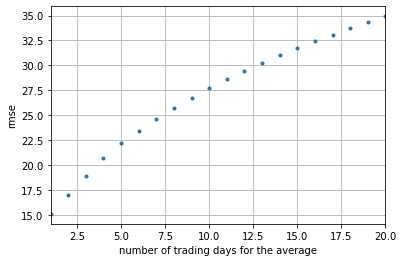

In [14]:
def train_and_test_2(features, target):
    '''
    trains a linear regression model and prints the rmse for the test data, 
    returns the rmse
    '''

    # build and train the model
    lr1 = LinearRegression()
    lr1.fit(train[features], train[target])

    # test the model and return the root-mean-squared error
    rmse1 = sqrt(mean_squared_error(lr1.predict(test[features]), test[target]))

    return rmse1

n_days_max = 20
res = []
for n in range(1, n_days_max+1):
    
    # compute the rolling average over the past n trading days
    data['mean_'+str(n)+'_Adj_Close'] = mean_n_trading_days('Adj Close', n)
    
    train = data[(data['Date'] >= datetime.strptime('01-01-1951', '%d-%m-%Y')) & (data['Date'] < datetime.strptime('01-01-2013', '%d-%m-%Y'))]
    test = data[data['Date'] >= datetime.strptime('01-01-2013', '%d-%m-%Y')]
    
    res.append(train_and_test_2(['mean_'+str(n)+'_Adj_Close'], 'Adj Close'))

plt.plot(range(1, n_days_max+1), res, r'.')
plt.grid()
plt.xlabel('number of trading days for the average')
plt.ylabel('rmse')
plt.xlim(1, n_days_max)
plt.show()

It seems that **the best results are obtained when taking only the adjusted closing price of the previous day into account.**
Let us see whether this model fares better than simply assuming this price does not change from one day to the other, denoted as the ‘naive rmse’ in the following:

In [15]:
rmse_naive = sqrt(((test[target] - test[target].shift(periods=1))**2).mean())
print('(rmse of the model) / (naive rmse): ' + str(res[0] / rmse_naive))

(rmse of the model) / (naive rmse): 1.002916871127206


Our model does not perform better than this naive approach. 
It thus **captures no information about the evolution of the adjusted closing price**.

## Adding momentum

Let us now try with the average over $n$ and $2n$ days, to see if the model can make use of the momentum.

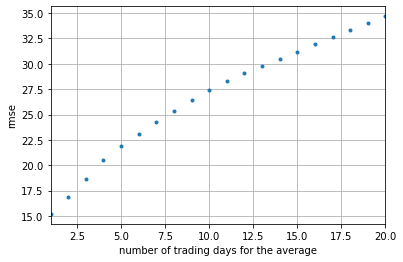

In [16]:
n_days_max = 20
res = []
for n in range(1, n_days_max+1):
    
    # compute the rolling average over the past n trading days
    data['mean_'+str(n)+'_Adj_Close'] = mean_n_trading_days('Adj Close', n)
    
    # compute the rolling average over the previous 2n trading days
    data['mean_'+str(n)+'_Adj_Close_2'] = mean_n_trading_days('Adj Close', 2*n)
    
    train = data[(data['Date'] >= datetime.strptime('01-01-1951', '%d-%m-%Y')) & (data['Date'] < datetime.strptime('01-01-2013', '%d-%m-%Y'))]
    test = data[data['Date'] >= datetime.strptime('01-01-2013', '%d-%m-%Y')]
    
    res.append(train_and_test_2(['mean_'+str(n)+'_Adj_Close', 'mean_'+str(n)+'_Adj_Close_2'], 'Adj Close'))

plt.plot(range(1, n_days_max+1), res, r'.')
plt.grid()
plt.xlabel('number of trading days for the average')
plt.ylabel('rmse')
plt.xlim(1, n_days_max)
plt.show()

Results are no better than the previous ones.

## Day of the week

Finally, let us try to take the day of the week into account:

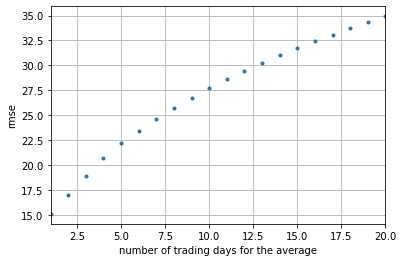

In [17]:
n_days_max = 20
res = []
for n in range(1, n_days_max+1):
    
    # copy the original dataframe
    data_ = data.copy()
    
    # compute the rolling average over the past n trading days
    data_['mean_'+str(n)+'_Adj_Close'] = mean_n_trading_days('Adj Close', n)
    
    # day of the weeks in one-hot format
    data_ = pd.concat([data_, pd.get_dummies(data_['Date'].dt.weekday, prefix='day')], axis=1)
    
    train = data_[(data['Date'] >= datetime.strptime('01-01-1951', '%d-%m-%Y')) & (data['Date'] < datetime.strptime('01-01-2013', '%d-%m-%Y'))]
    test = data_[data['Date'] >= datetime.strptime('01-01-2013', '%d-%m-%Y')]
    
    res.append(train_and_test_2(['mean_'+str(n)+'_Adj_Close'] + ['day_' + str(i) for i in range(5)], 'Adj Close'))

plt.plot(range(1, n_days_max+1), res, r'.')
plt.grid()
plt.xlabel('number of trading days for the average')
plt.ylabel('rmse')
plt.xlim(1, n_days_max)
plt.show()

Results are again very close to the previous ones. 
So, including the day of the week does not seem to improve the model. 

## Conclusion

In this project, we built a simple linear regression model to predict the adjusted closing price of the S&P index from past data. 
We reached the disappointing result that the best model we could build fares no better than just looking at the previous adjusted closing price and assuming the next one will be identical. 
This indicates that, from the point of view of the variables indicators we considered (*i.e.*, essentially the averaged prices over several days, a month, or a year), the day-to-day price fluctuations are essentially random. 
This is an illustration of the well-known ‘market efficiency’ principle stating (to say it informally) that it is difficult to predict the direction the market will move in and make gains predictably. 